In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from statistics import mean, median
from pathlib import Path
import sys
import matplotlib.pyplot as plt


In [ ]:
BASE_PATH = Path.cwd().parent
TESTING_FILES_BASE_PATH = BASE_PATH/"testing"/"files"
sys.path.append(str(BASE_PATH))

In [ ]:
from model.main import EMOTIONS
print(EMOTIONS)

def plot_beliefs(belief_user, belief_character, belief_user_character):
    x = np.arange(len(EMOTIONS))
    width = 0.25  # Slightly smaller width to fit 3 bars

    label1 = "System's belief about User"
    label2 = "System's belief about other character"
    label3 = "System's belief about User's belief about other character"

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, belief_user, width, label=label1)
    bars2 = ax.bar(x, belief_character, width, label=label2)
    bars3 = ax.bar(x + width, belief_user_character, width, label=label3)

    ax.set_xlabel('Mental States')
    ax.set_ylabel('Probability')
    ax.set_title('Belief Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(EMOTIONS)
    ax.legend()

    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Entropy: using log base 2
def entropy(dist):
    dist = np.array(dist)
    dist = dist[dist > 0]  # Avoid log(0)
    return -np.sum(dist * np.log2(dist))

In [ ]:
# Takes data from neg_correlation_emotions, pos_correlation_emotions and uncorrelated_emotions distributions
# Generates stats on distribution divergence (Jensen-Shannon divergence) 
class TestCaseDivergence():
    # Read files and generate stats
    def __init__(self, folder_path_dists, file_path_messages):
        with open(file_path_messages, encoding="utf-8") as f_explicit:
            self.messages = f_explicit.read().split("\n")

        self.num_files = len(self.messages)
        self.System_beliefs_user = [] # dist 1: System's belief of User
        self.System_beliefs_character = [] # dist 2: System's belief of other character
        self.System_beliefs_users_belief_character = [] # dist 3: System's belief of User's belief of other character
        self.jsds_1_2 = []
        self.jsds_1_3 = []
        self.jsds_2_3 = []

        for i in range(self.num_files):
            df = pd.read_csv(folder_path_dists/("message_"+str(i+1)+"_belief_dist.csv"))
            self.System_beliefs_user.append(df["Prob_System_belief_User"])
            self.System_beliefs_character.append(df["Prob_System_belief_Character"])
            self.System_beliefs_users_belief_character.append(df["Prob_System_belief_User_belief_Character"])

            # Jensen-Shannon Divergences
            jsd_1_2 = jensenshannon(df["Prob_System_belief_User"], df["Prob_System_belief_Character"])
            self.jsds_1_2.append(jsd_1_2)

            jsd_1_3 = jensenshannon(df["Prob_System_belief_User"], df["Prob_System_belief_User_belief_Character"])
            self.jsds_1_3.append(jsd_1_3)

            jsd_2_3 = jensenshannon(df["Prob_System_belief_Character"], df["Prob_System_belief_User_belief_Character"])
            self.jsds_2_3.append(jsd_2_3)
            
    def display_stats(self):
        for i in range(self.num_files):
            print("\n------------------------------------------------------------------" \
            "\n"+str(i+1)+"-User message:", self.messages[i])
            plot_beliefs(self.System_beliefs_user[i], self.System_beliefs_character[i], self.System_beliefs_users_belief_character[i])
            print("JSD - between System's belief of User & System's belief of other character: ", self.jsds_1_2[i])
            
            print("JSD - between System's belief of User & System's belief of User's belief of other character: ", self.jsds_1_3[i])
            
            print("JSD - between System's belief of Other character & System's belief of User's belief of other character: ", self.jsds_2_3[i])
            

In [ ]:
# Takes data from user_emotions_explicit_character_emotions_explicit,
#                 user_emotions_explicit_character_emotions_implicit,
#                 user_emotions_implicit_character_emotions_explicit,
#                 user_emotions_implicit_character_emotions_implicit,
# Generates stats on entropy
class TestCaseEntropy():
    # Read files and generate stats
    def __init__(self, folder_path_dists, file_path_messages):
        with open(file_path_messages, encoding="utf-8") as f_explicit:
            self.messages = f_explicit.read().split("\n")

        self.num_files = len(self.messages)
        self.System_beliefs_user = [] # dist 1: System's belief of User
        self.System_beliefs_character = [] # dist 2: System's belief of other character
        self.System_beliefs_users_belief_character = [] # dist 3: System's belief of User's belief of other character
        self.entropies_1 = [] # Entropy of dist 1
        self.entropies_2 = [] # Entropy of dist 2
        self.entropies_3 = [] # Entropy of dist 3

        for i in range(self.num_files):
            df = pd.read_csv(folder_path_dists/("message_"+str(i+1)+"_belief_dist.csv"))
            self.System_beliefs_user.append(df["Prob_System_belief_User"])
            self.System_beliefs_character.append(df["Prob_System_belief_Character"])
            self.System_beliefs_users_belief_character.append(df["Prob_System_belief_User_belief_Character"])

            self.entropies_1.append(entropy(df["Prob_System_belief_User"]))
            self.entropies_2.append(entropy(df["Prob_System_belief_Character"]))
            self.entropies_3.append(entropy(df["Prob_System_belief_User_belief_Character"]))


    def display_stats(self):
        for i in range(self.num_files):
            print("\n------------------------------------------------------------------" \
            "\n"+str(i+1)+"-User message:", self.messages[i])
            plot_beliefs(self.System_beliefs_user[i], self.System_beliefs_character[i], self.System_beliefs_users_belief_character[i])
            print("Entropy - System's belief of User: ", self.entropies_1[i])
            print("Entropy - System's belief of other character: ", self.entropies_2[i])
            print("Entropy - System's belief of User's belief of other character: ", self.entropies_3[i])
            

Get and display all results individually

In [ ]:
DISTRIBUTIONS_BASE_PATH = TESTING_FILES_BASE_PATH/"distributions"
MESSAGES_BASE_PATH = TESTING_FILES_BASE_PATH/"messages"

# Divergence test cases
aligned_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"aligned_emotions", MESSAGES_BASE_PATH/"aligned_emotions.txt")
neither_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"neither_aligned_nor_unaligned_emotions", MESSAGES_BASE_PATH/"neither_aligned_nor_unaligned_emotions.txt")
unaligned_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"unaligned_emotions", MESSAGES_BASE_PATH/"unaligned_emotions.txt")


In [ ]:
# Display individual message stats
print("JENSON-SHANNON DIVERGENCE STATS \n\n")

print("Prompted to be alinged: \n")
aligned_test_case.display_stats()
print("Prompted to be neither aligned nor unaligned: \n")
neither_test_case.display_stats()
print("Prompted to be unaligned: \n")
unaligned_test_case.display_stats()

In [ ]:

# Entropy test cases
user_exp_character_exp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_explicit_character_emotions_explicit", MESSAGES_BASE_PATH/"user_emotions_explicit_character_emotions_explicit.txt")
user_exp_character_imp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_explicit_character_emotions_implicit", MESSAGES_BASE_PATH/"user_emotions_explicit_character_emotions_implicit.txt")
user_imp_character_exp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_implicit_character_emotions_explicit", MESSAGES_BASE_PATH/"user_emotions_implicit_character_emotions_explicit.txt")
user_imp_character_imp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_implicit_character_emotions_implicit", MESSAGES_BASE_PATH/"user_emotions_implicit_character_emotions_implicit.txt")

In [ ]:
# Display individual message stats
print("ENTROPY STATS \n\n")

print("Prompted for - User emotions explicit, other character emotions explicit: \n")
user_exp_character_exp_test_case.display_stats()

print("Prompted for - User emotions explicit, other character emotions implicit: \n")
user_exp_character_imp_test_case.display_stats()

print("Prompted for - User emotions implicit, other character emotions explicit: \n")
user_imp_character_exp_test_case.display_stats()

print("Prompted for - User emotions implicit, other character emotions implicit: \n")
user_imp_character_imp_test_case.display_stats()

High level overview

C:\Users\dchal\AppData\Local\Temp\ipykernel_14216\3532651529.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


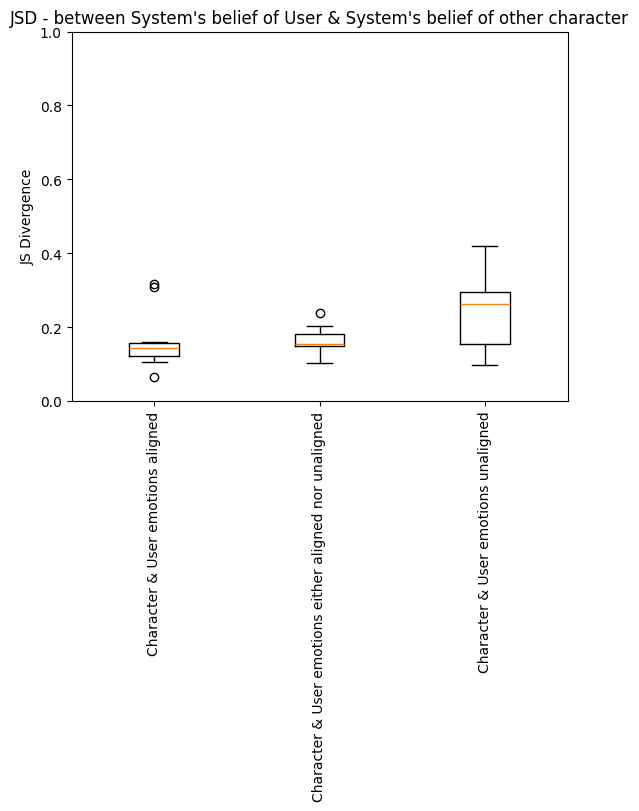

Means — Aligned: 0.1642, Neither: 0.1636, Unaligned: 0.2429
Medians — Aligned: 0.1446, Neither: 0.1559, Unaligned: 0.2631


C:\Users\dchal\AppData\Local\Temp\ipykernel_14216\3532651529.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


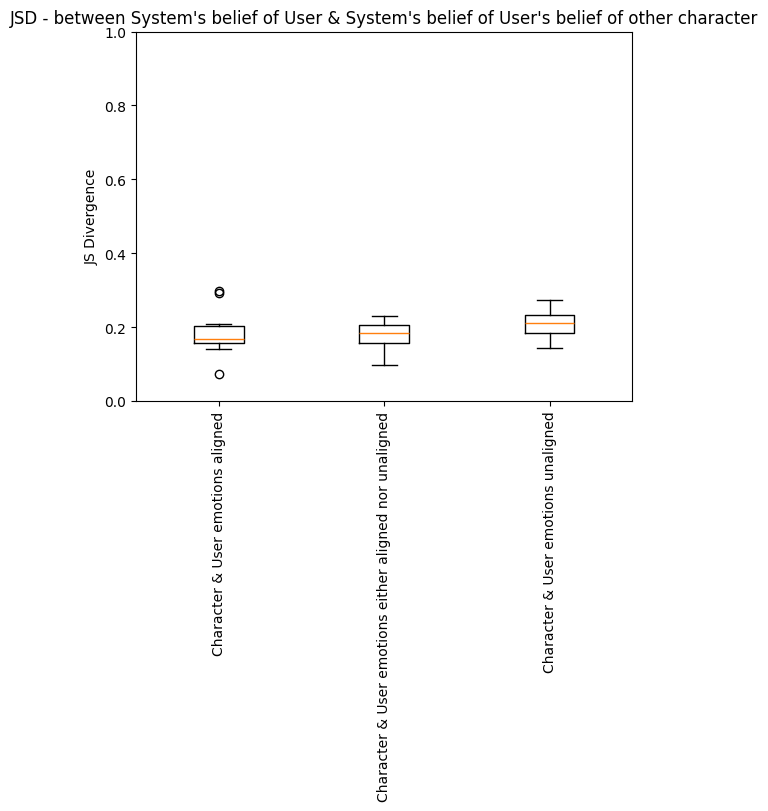

Means — Aligned: 0.1858, Neither: 0.1768, Unaligned: 0.2097
Medians — Aligned: 0.1689, Neither: 0.1835, Unaligned: 0.2115


C:\Users\dchal\AppData\Local\Temp\ipykernel_14216\3532651529.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


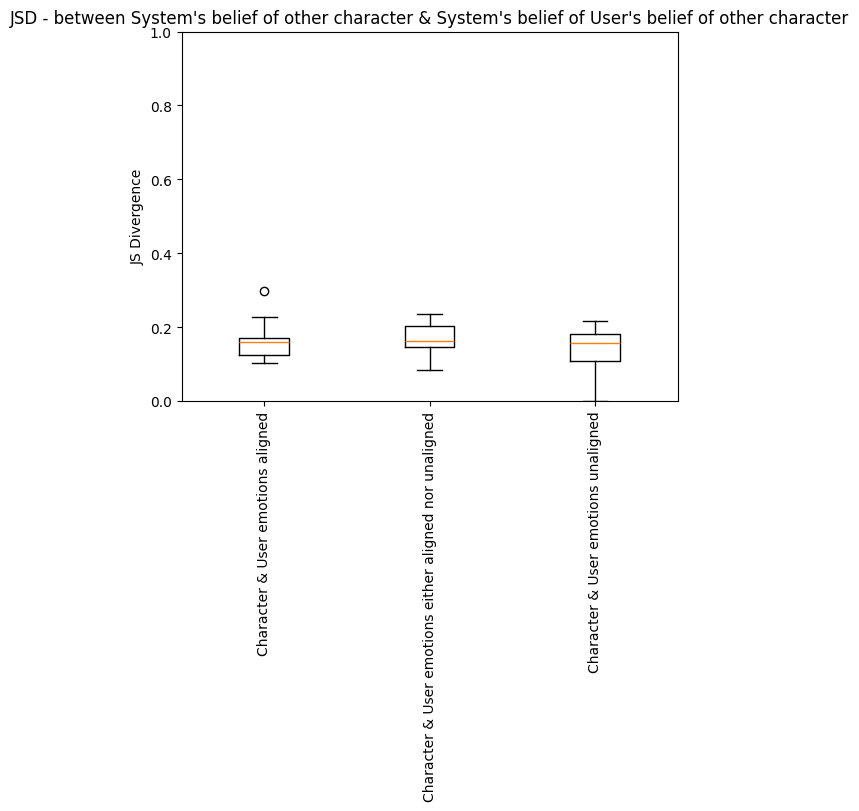

Means — Aligned: 0.1664, Neither: 0.1659, Unaligned: 0.1393
Medians — Aligned: 0.1591, Neither: 0.1614, Unaligned: 0.1561


In [14]:
def show_aggregated_results_divergence(aligned_test_case, neither_test_case, unaligned_test_case):
    num_files = aligned_test_case.num_files
    labels = [
        'Character & User emotions aligned', 'Character & User emotions either aligned nor unaligned', 'Character & User emotions unaligned'
    ]

    # JSD - between System's belief of User & System's belief of other character
    plt.boxplot([
        aligned_test_case.jsds_1_2,
        neither_test_case.jsds_1_2,
        unaligned_test_case.jsds_1_2,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of User & System's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()
    print(f"Means — Aligned: {mean(aligned_test_case.jsds_1_2):.4f}, Neither: {mean(neither_test_case.jsds_1_2):.4f}, Unaligned: {mean(unaligned_test_case.jsds_1_2):.4f}")
    print(f"Medians — Aligned: {median(aligned_test_case.jsds_1_2):.4f}, Neither: {median(neither_test_case.jsds_1_2):.4f}, Unaligned: {median(unaligned_test_case.jsds_1_2):.4f}")
    

    # JSD - between System's belief of User & System's belief of User's belief of other character
    plt.boxplot([
        aligned_test_case.jsds_1_3,
        neither_test_case.jsds_1_3,
        unaligned_test_case.jsds_1_3,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of User & System's belief of User's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()
    print(f"Means — Aligned: {mean(aligned_test_case.jsds_1_3):.4f}, Neither: {mean(neither_test_case.jsds_1_3):.4f}, Unaligned: {mean(unaligned_test_case.jsds_1_3):.4f}")
    print(f"Medians — Aligned: {median(aligned_test_case.jsds_1_3):.4f}, Neither: {median(neither_test_case.jsds_1_3):.4f}, Unaligned: {median(unaligned_test_case.jsds_1_3):.4f}")
    

    # JSD - between System's belief of other character & System's belief of User's belief of other character
    plt.boxplot([
        aligned_test_case.jsds_2_3,
        neither_test_case.jsds_2_3,
        unaligned_test_case.jsds_2_3,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of other character & System's belief of User's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()
    print(f"Means — Aligned: {mean(aligned_test_case.jsds_2_3):.4f}, Neither: {mean(neither_test_case.jsds_2_3):.4f}, Unaligned: {mean(unaligned_test_case.jsds_2_3):.4f}")
    print(f"Medians — Aligned: {median(aligned_test_case.jsds_2_3):.4f}, Neither: {median(neither_test_case.jsds_2_3):.4f}, Unaligned: {median(unaligned_test_case.jsds_2_3):.4f}")
    


show_aggregated_results_divergence(aligned_test_case, neither_test_case, unaligned_test_case)


C:\Users\dchal\AppData\Local\Temp\ipykernel_14216\2084119356.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


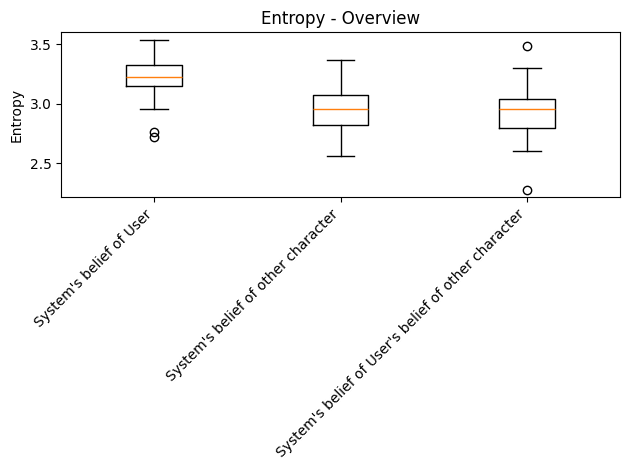

C:\Users\dchal\AppData\Local\Temp\ipykernel_14216\2084119356.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


Means — System's belief of user: 3.2119
 System's belief of other character: 2.9619
 System's belief of User's belief of other character: 2.9288
Medians — System's belief of user: 3.2248
 System's belief of other character: 2.9522
 System's belief of User's belief of other character: 2.9522


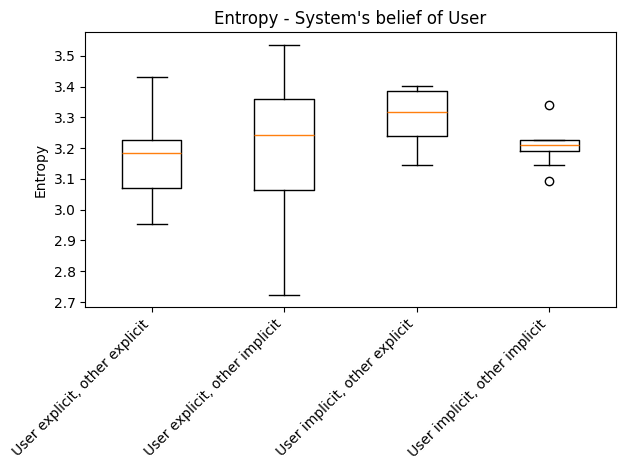

Means — User explicit, other character explicit: 3.1699
 User explicit, other character implicit: 3.1760
 User implicit, other character explicit: 3.2952
 User implicit, other character implicit: 3.2065

Medians — User explicit, other character explicit: 3.1828
 User explicit, other character implicit: 3.2437
 User implicit, other character explicit: 3.3164
 User implicit, other character implicit: 3.2087



C:\Users\dchal\AppData\Local\Temp\ipykernel_14216\2084119356.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


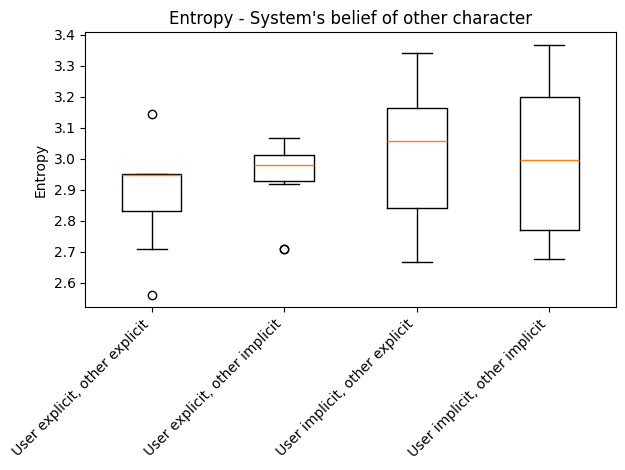

Means — User explicit, other character explicit: 2.8851
 User explicit, other character implicit: 2.9391
 User implicit, other character explicit: 3.0214
 User implicit, other character implicit: 3.0022

Medians — User explicit, other character explicit: 2.9493
 User explicit, other character implicit: 2.9806
 User implicit, other character explicit: 3.0562
 User implicit, other character implicit: 2.9968



C:\Users\dchal\AppData\Local\Temp\ipykernel_14216\2084119356.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


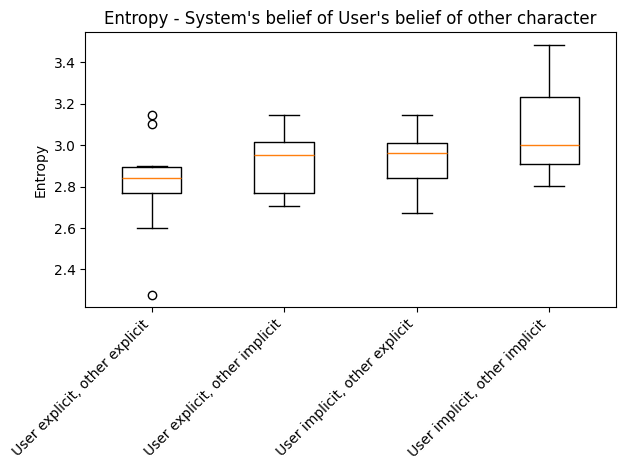

Means — User explicit, other character explicit: 2.8126
 User explicit, other character implicit: 2.9117
 User implicit, other character explicit: 2.9256
 User implicit, other character implicit: 3.0654

Medians — User explicit, other character explicit: 2.8396
 User explicit, other character implicit: 2.9522
 User implicit, other character explicit: 2.9616
 User implicit, other character implicit: 3.0001



In [15]:
def show_aggregated_results_enotropy(user_exp_character_exp_test_case, user_exp_character_imp_test_case, user_imp_character_exp_test_case, user_imp_character_imp_test_case):
    num_files = len(user_exp_character_exp_test_case.entropies_1)
    labels_cases = [
        "System's belief of User",
        "System's belief of other character",
        "System's belief of User's belief of other character"
    ]
    labels_subcases = [
        "User explicit, other explicit",
        "User explicit, other implicit",
        "User implicit, other explicit",
        "User implicit, other implicit"
    ]

    # Entropy - Overview
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_1 + user_exp_character_imp_test_case.entropies_1 + user_imp_character_exp_test_case.entropies_1 + user_imp_character_imp_test_case.entropies_1,
        user_exp_character_exp_test_case.entropies_2 + user_exp_character_imp_test_case.entropies_2 + user_imp_character_exp_test_case.entropies_2 + user_imp_character_imp_test_case.entropies_2,
        user_exp_character_exp_test_case.entropies_3 + user_exp_character_imp_test_case.entropies_3 + user_imp_character_exp_test_case.entropies_3 + user_imp_character_imp_test_case.entropies_3
    ], labels=labels_cases)
    plt.ylabel("Entropy")
    plt.title("Entropy - Overview")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user = mean(user_exp_character_exp_test_case.entropies_1 + user_exp_character_imp_test_case.entropies_1 + user_imp_character_exp_test_case.entropies_1 + user_imp_character_imp_test_case.entropies_1)
    mean_character = mean(user_exp_character_exp_test_case.entropies_2 + user_exp_character_imp_test_case.entropies_2 + user_imp_character_exp_test_case.entropies_2 + user_imp_character_imp_test_case.entropies_2)
    mean_user_character = mean(user_exp_character_exp_test_case.entropies_3 + user_exp_character_imp_test_case.entropies_3 + user_imp_character_exp_test_case.entropies_3 + user_imp_character_imp_test_case.entropies_3)
    print(f"Means — System's belief of user: {mean_user:.4f}\n System's belief of other character: {mean_character:.4f}\n System's belief of User's belief of other character: {mean_user_character:.4f}")

    median_user = median(user_exp_character_exp_test_case.entropies_1 + user_exp_character_imp_test_case.entropies_1 + user_imp_character_exp_test_case.entropies_1 + user_imp_character_imp_test_case.entropies_1)
    median_character = median(user_exp_character_exp_test_case.entropies_2 + user_exp_character_imp_test_case.entropies_2 + user_imp_character_exp_test_case.entropies_2 + user_imp_character_imp_test_case.entropies_2)
    median_user_character = median(user_exp_character_exp_test_case.entropies_3 + user_exp_character_imp_test_case.entropies_3 + user_imp_character_exp_test_case.entropies_3 + user_imp_character_imp_test_case.entropies_3)
    print(f"Medians — System's belief of user: {median_user:.4f}\n System's belief of other character: {median_character:.4f}\n System's belief of User's belief of other character: {median_user_character:.4f}")

    # Entropy - System's belief of User
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_1 ,
        user_exp_character_imp_test_case.entropies_1,
        user_imp_character_exp_test_case.entropies_1,
        user_imp_character_imp_test_case.entropies_1,
    ], labels=labels_subcases)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of User")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user_exp_character_exp = mean(user_exp_character_exp_test_case.entropies_1)
    mean_user_exp_character_imp = mean(user_exp_character_imp_test_case.entropies_1)
    mean_user_imp_character_exp = mean(user_imp_character_exp_test_case.entropies_1)
    mean_user_imp_character_imp = mean(user_imp_character_imp_test_case.entropies_1)
    print(f"Means — User explicit, other character explicit: {mean_user_exp_character_exp:.4f}\n User explicit, other character implicit: {mean_user_exp_character_imp:.4f}\n User implicit, other character explicit: {mean_user_imp_character_exp:.4f}\n User implicit, other character implicit: {mean_user_imp_character_imp:.4f}\n")

    median_user_exp_character_exp = median(user_exp_character_exp_test_case.entropies_1)
    median_user_exp_character_imp = median(user_exp_character_imp_test_case.entropies_1)
    median_user_imp_character_exp = median(user_imp_character_exp_test_case.entropies_1)
    median_user_imp_character_imp = median(user_imp_character_imp_test_case.entropies_1)
    print(f"Medians — User explicit, other character explicit: {median_user_exp_character_exp:.4f}\n User explicit, other character implicit: {median_user_exp_character_imp:.4f}\n User implicit, other character explicit: {median_user_imp_character_exp:.4f}\n User implicit, other character implicit: {median_user_imp_character_imp:.4f}\n")

    # Entropy - System's belief of other character
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_2,
        user_exp_character_imp_test_case.entropies_2,
        user_imp_character_exp_test_case.entropies_2,
        user_imp_character_imp_test_case.entropies_2,
    ], labels=labels_subcases)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of other character")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user_exp_character_exp = mean(user_exp_character_exp_test_case.entropies_2)
    mean_user_exp_character_imp = mean(user_exp_character_imp_test_case.entropies_2)
    mean_user_imp_character_exp = mean(user_imp_character_exp_test_case.entropies_2)
    mean_user_imp_character_imp = mean(user_imp_character_imp_test_case.entropies_2)
    print(f"Means — User explicit, other character explicit: {mean_user_exp_character_exp:.4f}\n User explicit, other character implicit: {mean_user_exp_character_imp:.4f}\n User implicit, other character explicit: {mean_user_imp_character_exp:.4f}\n User implicit, other character implicit: {mean_user_imp_character_imp:.4f}\n")

    median_user_exp_character_exp = median(user_exp_character_exp_test_case.entropies_2)
    median_user_exp_character_imp = median(user_exp_character_imp_test_case.entropies_2)
    median_user_imp_character_exp = median(user_imp_character_exp_test_case.entropies_2)
    median_user_imp_character_imp = median(user_imp_character_imp_test_case.entropies_2)
    print(f"Medians — User explicit, other character explicit: {median_user_exp_character_exp:.4f}\n User explicit, other character implicit: {median_user_exp_character_imp:.4f}\n User implicit, other character explicit: {median_user_imp_character_exp:.4f}\n User implicit, other character implicit: {median_user_imp_character_imp:.4f}\n")


    # Entropy - System's belief of User's belief of other character
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_3,
        user_exp_character_imp_test_case.entropies_3,
        user_imp_character_exp_test_case.entropies_3,
        user_imp_character_imp_test_case.entropies_3,
    ], labels=labels_subcases)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of User's belief of other character")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user_exp_character_exp = mean(user_exp_character_exp_test_case.entropies_3)
    mean_user_exp_character_imp = mean(user_exp_character_imp_test_case.entropies_3)
    mean_user_imp_character_exp = mean(user_imp_character_exp_test_case.entropies_3)
    mean_user_imp_character_imp = mean(user_imp_character_imp_test_case.entropies_3)
    print(f"Means — User explicit, other character explicit: {mean_user_exp_character_exp:.4f}\n User explicit, other character implicit: {mean_user_exp_character_imp:.4f}\n User implicit, other character explicit: {mean_user_imp_character_exp:.4f}\n User implicit, other character implicit: {mean_user_imp_character_imp:.4f}\n")

    median_user_exp_character_exp = median(user_exp_character_exp_test_case.entropies_3)
    median_user_exp_character_imp = median(user_exp_character_imp_test_case.entropies_3)
    median_user_imp_character_exp = median(user_imp_character_exp_test_case.entropies_3)
    median_user_imp_character_imp = median(user_imp_character_imp_test_case.entropies_3)
    print(f"Medians — User explicit, other character explicit: {median_user_exp_character_exp:.4f}\n User explicit, other character implicit: {median_user_exp_character_imp:.4f}\n User implicit, other character explicit: {median_user_imp_character_exp:.4f}\n User implicit, other character implicit: {median_user_imp_character_imp:.4f}\n")


show_aggregated_results_enotropy(user_exp_character_exp_test_case, user_exp_character_imp_test_case, user_imp_character_exp_test_case, user_imp_character_imp_test_case)